## Sandbox for Implementing RetinaNet

- start wih pretrined resnet50, maybe from the original paper, or mybe from fastai, doesn't really matter
- then add feature pyramid network and finetune for coco

## General Approach

1. Download CamVid
- Build and train U-Net
- Download COCO
- Build Feature Pyramid Network (FPN) with ResNet backbone
- Build and train RetinaNet with FPN and object detection subnets

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *

## CamVid

In [3]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

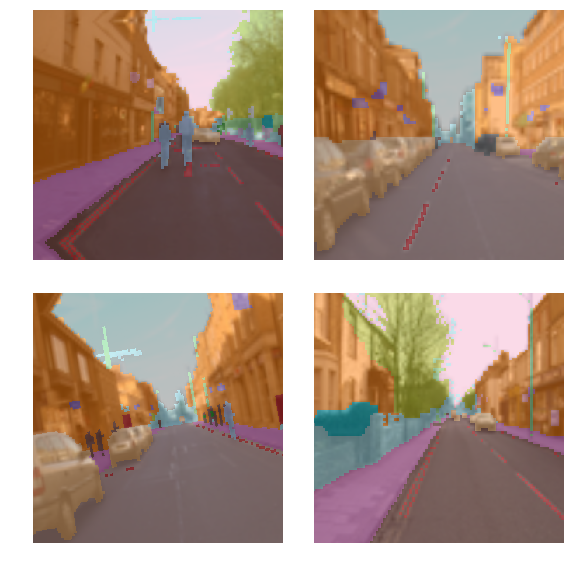

In [4]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=572)
        .databunch())
data.show_batch(2)

## U-Net

In [9]:
def conv(ic, oc, k=3, s=1, p=0, actn=True):
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=p)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

def conv_block(ic, oc): return nn.Sequential(conv(ic, oc), conv(oc, oc), nn.MaxPool2d(2, stride=2))
def unet_down(cs): return nn.Sequential(*[conv_block(cs[i], cs[i+1]) for i in range(len(cs)-1)])

class SaveMap():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): self.map = out
    def remove(self): self.hook.remove()
        
class UNet(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.layers = backbone
        self.maps = [SaveMap(block[-2]) for block in children(backbone)]
        
    def forward(x):
        return self.layers(x)
    
    def close():
        for mp in self.maps: mp.remove()

In [6]:
cs = [3, 64, 128, 256, 512, 1024]
model = UNet(unet_down(cs))

In [7]:
data.one_batch()[0].shape

torch.Size([64, 3, 572, 572])

In [8]:
model(data.one_batch()[0])

TypeError: forward() takes 1 positional argument but 2 were given

In [19]:
children(model)

[Sequential(
   (0): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU(inplace)
   )
   (1): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU(inplace)
   )
   (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 ), Sequential(
   (0): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU(inplace)
   )
   (1): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU(inplace)
   )
   (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 ), Sequential(
   (0): Sequential(
     (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU(inplace)
   )
   (1): Sequential(
     (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU(inplace)
   )
   (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 ), Sequential(
   (0): Sequential(
     (0): 